In [1]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# FLD Model

In [2]:
class FLD:
  def __init__(self, n_components=1):
    """
        You can add/change any variables/methods to meet your need.
    """
    self.mean_vectors = None
    self.sw = None
    self.sb = None
    self.w = None
    self.n_components = n_components

  def fit(self, X, y):
    n_samples, n_features = X.shape
    class_labels = np.unique(y)

    # Compute the mean vectors for each class
    self.mean_vectors = []
    self.sw = np.zeros((n_features, n_features))
    self.sb = np.zeros((n_features, n_features))
    mean_total = np.mean(X, axis=0).reshape((n_features, 1))
    for i in range(len(class_labels)):
      label = class_labels[i]
      self.mean_vectors.append(np.mean(X[y == label], axis=0))
      Xi = X[y == label]-self.mean_vectors[i]

      # Compute the within-class scatter matrix Sw
      SWi = np.dot(Xi.T,Xi)
      self.sw+=SWi

      # Compute the between-class scatter matrix Sb
      mean_vec = self.mean_vectors[i].reshape((n_features, 1))
      Mi = mean_vec - mean_total
      SBi = len(X[y == label])*np.dot(Mi,Mi.T)
      self.sb+=SBi

    eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(self.sw), self.sb))
    # Sort the eigenvectors by decreasing eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:, idx]
    # Select the first n_components big eigenvectors
    self.w = eigenvectors[:, :self.n_components]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return np.dot(X, self.w)

  def predict_using_class_mean(self, X, y, X_test):
    X_train_transformed = self.fit_transform(X, y)
    X_test_transformed = np.dot(X_test, self.w)
    # Calculate the class means
    class_means = []
    for label in np.unique(y):
      class_mean = np.mean(X_train_transformed[y == label], axis=0)
      class_means.append(class_mean)

    distances = []
    for class_mean in class_means:
      distance = np.linalg.norm((X_test_transformed - class_mean),axis=1)
      distances.append(distance)

    y_pred = np.argmin(distances, axis=0)

    # Convert the prediction to original class labels
    unique_labels = np.unique(y)
    y_pred = [unique_labels[label] for label in y_pred]

    return y_pred

  def predict_using_knn(self, X, y, X_test, k=1):
    X_train_transformed = self.fit_transform(X, y)
    X_test_transformed = np.dot(X_test, self.w)

    y_pred = []
    for i in range(len(X_test_transformed)):
      dist = np.linalg.norm((X_test_transformed[i]-X_train_transformed),axis=1)
      nearest_labels = y[np.argsort(dist)[:k]]
      label_counts = np.bincount(nearest_labels)
      y_pred.append(np.argmax(label_counts))
    
    return y_pred

  def show_confusion_matrix(self, y, y_pred):
    # Compute confusion matrix using numpy
    cm = np.zeros((3, 3))
    for i in range(len(y)):
      cm[y[i], y_pred[i]] += 1

    # Plot confusion matrix using matplotlib
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Add labels and title
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['0', '1', '2'])
    ax.set_yticklabels(['0', '1', '2'])
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')

    # Add annotations
    for i in range(3):
      for j in range(3):
        text = ax.text(j,i,int(cm[i, j]),ha='center', va='center', color='white')
    
    plt.colorbar(im)
    # Show plot
    plt.show()

  def plot_projection(self, X, y):
    unique_labels = np.unique(y)
    plt.figure(figsize=(12.8,9.6))
    b = self.w[-1]
    m = self.w[:-1].reshape(-1)
    proj_X = (X[:,0] + (X[:,1]-b)*m) / (m * m + 1)
    proj_Y = proj_X * m + b
    plt.plot(proj_X, proj_Y, color='black', linewidth=0.5)

    for i in range(len(unique_labels)):
      X_label = X[y==unique_labels[i]]
      proj_X_label = (X_label[:,0] + (X_label[:,1]-b)*m) / (m * m + 1)
      proj_Y_label = proj_X_label * m + b

      if i==0:
        plt.scatter(X_label[:,0], X_label[:,1], c='blue', s=7)
        plt.scatter(proj_X_label, proj_Y_label, c='blue', s=7)
        plt.plot([X_label[:,0],proj_X_label.reshape(-1)], [X_label[:,1],proj_Y_label.reshape(-1)], \
                 color='blue', alpha=0.3, linewidth=0.3)
        
      elif i==1:
        plt.scatter(X_label[:,0], X_label[:,1], c='red', s=7)
        plt.scatter(proj_X_label, proj_Y_label, c='red', s=7)
        plt.plot([X_label[:,0],proj_X_label.reshape(-1)], [X_label[:,1],proj_Y_label.reshape(-1)], \
                 color='red', alpha=0.3, linewidth=0.3)
      else:
        plt.scatter(X_label[:,0], X_label[:,1], c='green', s=7)
        plt.scatter(proj_X_label, proj_Y_label, c='green', s=7)
        plt.plot([X_label[:,0],proj_X_label.reshape(-1)], [X_label[:,1],proj_Y_label.reshape(-1)], \
                 color='green', alpha=0.3, linewidth=0.3)
    plt.title('Projection Line: w={}, b={}'.format(self.w[:-1].reshape(-1)[0], self.w[-1][0]))
    plt.axis("scaled")
    plt.show()

  def accuracy_score(self, y, y_pred):
    accuracy_bool = y==y_pred
    return np.sum(accuracy_bool)/len(y)

# LogisticRegression Model

In [3]:
class MultiClassLogisticRegression:
  def __init__(self):
    """
    You can add/change any variables/methods to meet your need.
    """
    self.epoch = []
    self.train_loss = []
    self.weights = None

  def fit(self, X, y, batch_size=16, lr=0.001, epochs=100):
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))

    # 在X右方加入一行1對應到參數theta_0
    X = np.hstack([X, np.ones((n_samples,1))])

    # one-hot encoding for y
    y_onehot = np.zeros((n_samples, n_classes))
    y_onehot[np.arange(n_samples), y] = 1

    self.weights = np.random.randn((n_features+1),n_classes)

    for epoch in tqdm(range(epochs)):
      for batch in range(len(X)//batch_size):
        mini_batch_X = X[batch*batch_size:(batch+1)*batch_size]
        mini_batch_y = y_onehot[batch*batch_size:(batch+1)*batch_size]
        probs = self.predict(mini_batch_X)
        gradient = (1/batch_size) * np.dot(mini_batch_X.T, (probs - mini_batch_y))
        self.weights -= lr * gradient
      if(len(X)%batch_size!=0):
        mini_batch_X = X[batch*(len(X)//batch_size):]
        mini_batch_y = y_onehot[batch*(len(X)//batch_size):]
        probs = self.predict(mini_batch_X)
        gradient = (1/batch_size) * np.dot(mini_batch_X.T, (probs - mini_batch_y))
        self.weights -= lr * gradient

      self.epoch.append(epoch)
      self.train_loss.append(self.cross_entropy(X, y_onehot))

  def predict(self, X):
    y_hat = X.dot(self.weights)
    probs = self.softmax(y_hat)
    return probs

  def evaluate(self, X, y):
    # m 為資料筆數，n 為特徵數量
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))

    # 在X左方加入一行1對應到參數theta_0
    X = np.hstack([X, np.ones((n_samples, 1))])

    # one-hot encoding for y
    y_onehot = np.zeros((n_samples, n_classes))
    y_onehot[np.arange(n_samples), y] = 1

    probs = self.predict(X)
    y_pred = np.argmax(probs, axis=1)

    return self.accuracy_score(y, y_pred)

  def softmax(self, z):
    # 為了穩定地計算softmax概率，一般會減掉最大的那個元素
    z -= np.max(z, axis=1, keepdims=True)
    e_z = np.exp(z)
    return e_z / np.sum(e_z, axis=1, keepdims=True)

  def cross_entropy(self, X, y):
    probs = self.predict(X)
    loss = -np.mean(np.sum(y * np.log(probs), axis=1))
    return loss
  
  def accuracy_score(self, y, y_pred):
    accuracy_bool = y==y_pred
    return np.sum(accuracy_bool)/len(y)

  def show_confusion_matrix(self, X, y):
    n_samples, n_features = X.shape

    # 在X左方加入一行1對應到參數theta_0
    X = np.hstack([X, np.ones((n_samples, 1))])
    probs = self.predict(X)
    y_pred = np.argmax(probs, axis=1)

    # Compute confusion matrix using numpy
    cm = np.zeros((3, 3))
    for i in range(len(y)):
        cm[y[i], y_pred[i]] += 1

    # Plot confusion matrix using matplotlib
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Add labels and title
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['0', '1', '2'])
    ax.set_yticklabels(['0', '1', '2'])
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')

    # Add annotations
    for i in range(3):
      for j in range(3):
        text = ax.text(j,i,int(cm[i, j]),ha='center', va='center', color='white')
    
    plt.colorbar(im)
    # Show plot
    plt.show()

  def plot_curve(self):
    # self.epoch and self.train_loss may be helpful here.
    plt.plot(self.epoch, self.train_loss, color='red')
    plt.xlabel('epoch') # 設定 x 軸標題
    plt.ylabel('cross_entropy loss') # 設定 y 軸標題
    plt.show()

# Prepare data for Q1 ~ Q12

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_train = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw2/PR_HW2_dataset/PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw2/PR_HW2_dataset/PR_HW2_blob_test.csv"))

In [6]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


# MultiClass Logistic Regression

In [7]:
# For Q1
lr = 0.001
batch_size = len(X_train)
epoch = 10000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epochs=epoch)

100%|██████████| 10000/10000 [00:04<00:00, 2021.08it/s]


In [8]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.894


In [9]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.881


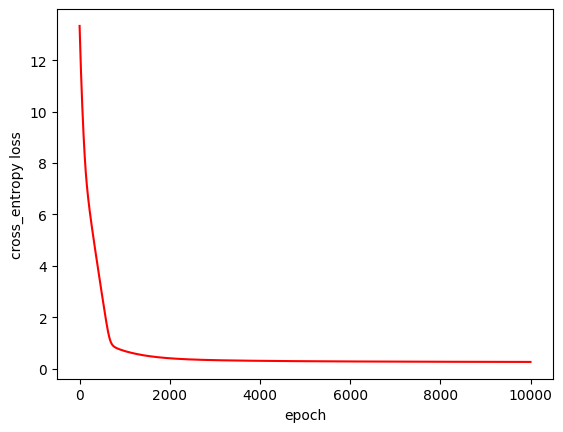

In [10]:
# For Q4
logistic_reg.plot_curve()

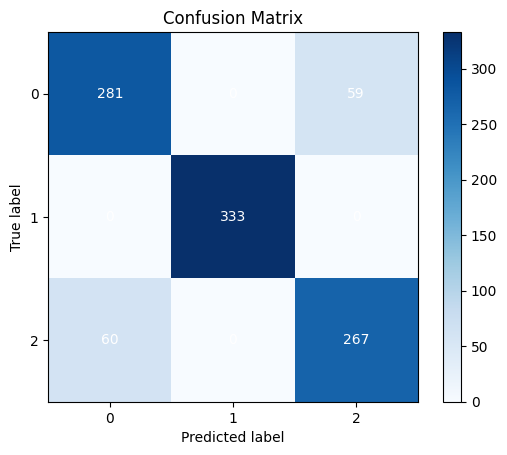

In [11]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

# Fisher's Linear Discriminant Analysis

In [12]:
fld = FLD(1)

fld.fit(X_train, y_train)

In [13]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [array([-4.17505764,  6.35526804]), array([-9.43385176, -4.87830741]), array([-2.54454008,  7.53144179])]


In [14]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [15]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [16]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384]
 [-0.8974315 ]]


FLD using class mean, accuracy:  0.861


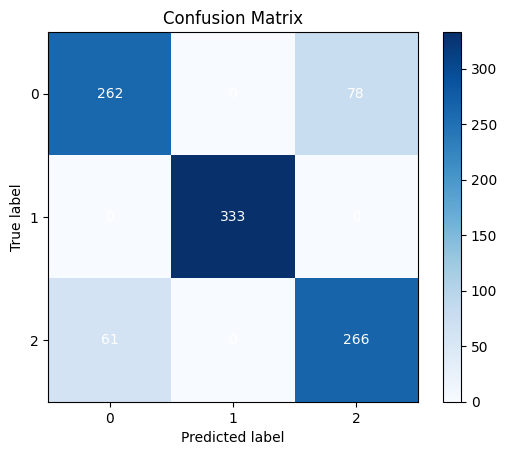

In [17]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [18]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.822
FLD using knn (k=2), accuracy:  0.819
FLD using knn (k=3), accuracy:  0.843
FLD using knn (k=4), accuracy:  0.84
FLD using knn (k=5), accuracy:  0.862


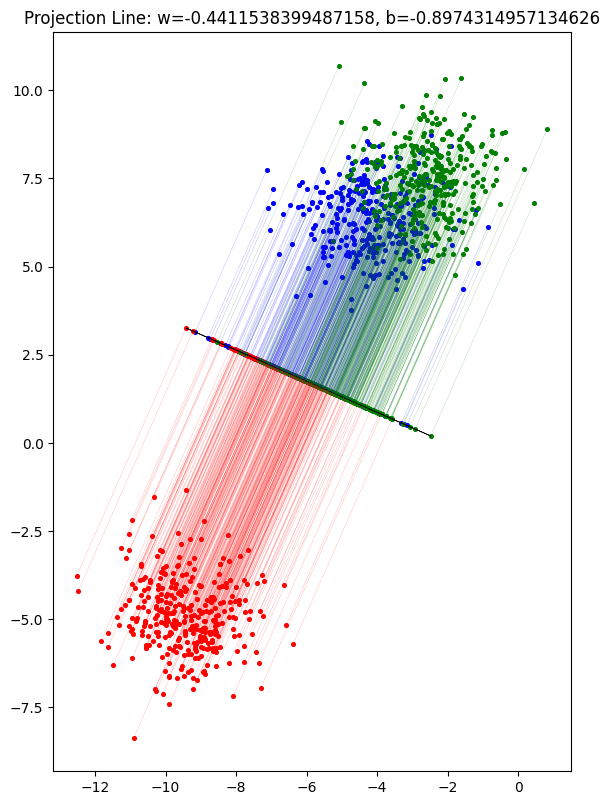

In [19]:
# For Q12, using only training data
# 點要垂直投影到線上
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [20]:
df_train = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw2/PR_HW2_dataset/PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw2/PR_HW2_dataset/PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw2/PR_HW2_dataset/PR_HW2_test.csv"))

In [21]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [22]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [23]:
poly_list = df_train.drop(['Target'], axis=1).columns
# poly_list = ['Feature2', 'Feature3', 'Feature4'] # k=10有到0.919
for i in range(len(poly_list)):
  for j in range(i, len(poly_list)):
    poly_name = poly_list[i]+'*'+poly_list[j]
    df_train[poly_name] = df_train[poly_list[i]] * df_train[poly_list[j]]
    df_val[poly_name] = df_val[poly_list[i]] * df_val[poly_list[j]]
    df_test[poly_name] = df_test[poly_list[i]] * df_test[poly_list[j]]

In [24]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target,Feature1*Feature1,Feature1*Feature2,Feature1*Feature3,Feature1*Feature4,Feature2*Feature2,Feature2*Feature3,Feature2*Feature4,Feature3*Feature3,Feature3*Feature4,Feature4*Feature4
0,0.00668,0.00192,0.682,0.996,2.0,0.000045,0.000013,0.004556,0.006653,0.000004,0.001309,0.001912,0.465124,0.679272,0.992016
1,0.00680,0.00106,0.503,0.996,1.0,0.000046,0.000007,0.003420,0.006773,0.000001,0.000533,0.001056,0.253009,0.500988,0.992016
2,0.00742,0.00106,0.482,0.991,1.0,0.000055,0.000008,0.003576,0.007353,0.000001,0.000511,0.001050,0.232324,0.477662,0.982081
3,0.00685,0.00178,0.650,0.998,2.0,0.000047,0.000012,0.004452,0.006836,0.000003,0.001157,0.001776,0.422500,0.648700,0.996004
4,0.00680,0.00163,0.623,0.996,2.0,0.000046,0.000011,0.004236,0.006773,0.000003,0.001015,0.001623,0.388129,0.620508,0.992016


In [25]:
corr_matrix = abs(df_train.corr())
sorted_corr_matrix = corr_matrix['Target'].sort_values(ascending=False).drop(['Target'])
print(sorted_corr_matrix[:8])
Feature_columns = sorted_corr_matrix[:8].index.tolist()
for poly_element in poly_list:
  if poly_element not in Feature_columns:
    Feature_columns.append(poly_element)
print(Feature_columns)

Feature1*Feature4    0.660107
Feature1             0.657016
Feature1*Feature1    0.649039
Feature1*Feature2    0.580368
Feature1*Feature3    0.553294
Feature2*Feature2    0.521436
Feature2*Feature4    0.478292
Feature2             0.477465
Name: Target, dtype: float64
['Feature1*Feature4', 'Feature1', 'Feature1*Feature1', 'Feature1*Feature2', 'Feature1*Feature3', 'Feature2*Feature2', 'Feature2*Feature4', 'Feature2', 'Feature3', 'Feature4']


In [26]:
# Data processing
X_train = df_train[Feature_columns].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel().astype(int)

X_val = df_val[Feature_columns].to_numpy()
y_val = df_val[['Target']].to_numpy().ravel().astype(int)

X_test = df_test[Feature_columns].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel().astype(int)

In [27]:
fld = FLD(2)
fld.fit(X_train, y_train)

In [28]:
y_pred = fld.predict_using_class_mean(X_train, y_train, X_val)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_val, y_pred))

FLD using class mean, accuracy:  0.8945205479452055


In [29]:
for i in range(1,11):
  y_pred_k = fld.predict_using_knn(X_train, y_train, X_val, k=i)
  print("FLD using knn (k={}), accuracy: {}".format(i, fld.accuracy_score(y_val, y_pred_k)))

FLD using knn (k=1), accuracy: 0.8698630136986302
FLD using knn (k=2), accuracy: 0.8904109589041096
FLD using knn (k=3), accuracy: 0.9123287671232877
FLD using knn (k=4), accuracy: 0.9164383561643835
FLD using knn (k=5), accuracy: 0.9136986301369863
FLD using knn (k=6), accuracy: 0.9178082191780822
FLD using knn (k=7), accuracy: 0.9191780821917809
FLD using knn (k=8), accuracy: 0.9178082191780822
FLD using knn (k=9), accuracy: 0.9232876712328767
FLD using knn (k=10), accuracy: 0.9205479452054794


In [30]:
test_pred = fld.predict_using_knn(X_train, y_train, X_test, k=9)
test_pred = np.array(test_pred)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


# Output the csv file

In [31]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Pattern_Recognition/hw2/PR_HW2_dataset/PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("/content/drive/MyDrive/Pattern_Recognition/hw2/311553030_prediction.csv")